# XGBoost

### Importing github repository

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("token")

!git clone https://{token}@github.com/Benedart/RecSys-2022-Challenge-Polimi.git

In [2]:
import os

os.chdir( "./RecSys-2022-Challenge-Polimi")

#### Compiling Cython files

In [ ]:
import os

os.chdir( "./RecSys-2022-Challenge-Polimi")
!python run_compile_all_cython.py

In [ ]:
!cp -r /kaggle/input/recsyslight/result_experiments/SKOPT_test/ result_experiments/SKOPT_test/

os.chdir("result_experiments/SKOPT_test")
! for i in */; do (cd "$i"; zip -r "../${i%/}.zip" .); done
! rm -R -- */
os.chdir("../..")

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps
import csv
import xgboost as xgb

from Recommenders.Recommender_import_list import *

#### Importing URM & ICM

In [4]:
URM_all = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/interactions_and_impressions.csv")
ICM_type = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_type.csv")
ICM_length = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_length.csv")

ICM_all = pd.concat([ICM_type, ICM_length]).sort_values(by='item_id')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
URM_all

UserID  ItemID                                        Impressions  \
0             0      11  0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19   
1             0      21                                                NaN   
2             0      21                                                NaN   
3             0      21                      20,21,22,23,24,25,26,27,28,29   
4             0      21                                                NaN   
...         ...     ...                                                ...   
5826501   41628   20448                                                NaN   
5826502   41628   20896                                                NaN   
5826503   41628   21506                                                NaN   
5826504   41628   22882                                                NaN   
5826505   41628   23757                                                NaN   

         Data  
0           1  
1           0  
2           0  
3           0  
4           1  
...       ...  
5826501     0  
5826502     1  
5826503     1  
5826504     0  
5826505     0  

[5826506 rows x 4 columns]

In [6]:
ICM_all

item_id  feature_id  data
0            0           1     1
0            0           0     1
1            1           0     1
1            1           3     1
2            2           4     1
...        ...         ...   ...
23088    27965           1     1
23089    27966           0     1
23089    27966           1     1
23090    27967           4     1
23090    27967           0     2

[46182 rows x 3 columns]

#### Getting rid of duplicates and empty indices
Let's start with the indices, the mapping is done for consistency

In [7]:
mapped_id, original_id = pd.factorize(URM_all["UserID"].unique())
user_original_Id_to_index = pd.Series(mapped_id, index=original_id)

print("Unique UserID in the URM are {}".format(len(original_id)))

mapped_id, original_id = pd.factorize(URM_all["ItemID"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_all["ItemID"], ICM_all["item_id"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM are {}".format(len(original_id)))

item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(ICM_all["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique FeatureID in the URM are {}".format(len(feature_original_ID_to_index)))

URM_all["UserID"] = URM_all["UserID"].map(user_original_Id_to_index)
URM_all["ItemID"] = URM_all["ItemID"].map(item_original_ID_to_index)
ICM_all["item_id"] = ICM_all["item_id"].map(item_original_ID_to_index)
ICM_all["feature_id"] = ICM_all["feature_id"].map(feature_original_ID_to_index)

Unique UserID in the URM are 41629
Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM are 27968
Unique FeatureID in the URM are 6


And then we remove duplicate values

In [8]:
URM_all = URM_all.drop(["Impressions", "Data"], axis=1).drop_duplicates()
URM_all["Rating"] = 1

In [9]:
URM_all

UserID  ItemID  Rating
0             0       0       1
1             0       1       1
13            0       2       1
28            0       3       1
29            0       4       1
...         ...     ...     ...
5826501   41628    3700       1
5826502   41628   12694       1
5826503   41628   15132       1
5826504   41628   18128       1
5826505   41628   14573       1

[1554640 rows x 3 columns]

In [10]:
ICM_type

item_id  feature_id  data
0            0           1     1
1            1           3     1
2            2           4     1
3            3           1     1
4            4           3     1
...        ...         ...   ...
23086    27963           1     1
23087    27964           2     1
23088    27965           1     1
23089    27966           1     1
23090    27967           4     1

[23091 rows x 3 columns]

In [11]:
ICM_length

item_id  feature_id  data
0            0           0     1
1            1           0     1
2            2           0    21
3            3           0     1
4            4           0     1
...        ...         ...   ...
23086    27963           0     1
23087    27964           0     1
23088    27965           0     1
23089    27966           0     1
23090    27967           0     2

[23091 rows x 3 columns]

In [12]:
ICM_all

item_id  feature_id  data
0         3668           0     1
0         3668           1     1
1         1945           1     1
1         1945           2     1
2        18373           3     1
...        ...         ...   ...
23088    27965           0     1
23089    27966           1     1
23089    27966           0     1
23090    27967           3     1
23090    27967           1     2

[46182 rows x 3 columns]

#### Creating the matrices

In [13]:
n_users = len(user_original_Id_to_index)
n_items = len(item_original_ID_to_index)
n_features = len(feature_original_ID_to_index)

from sklearn.model_selection import train_test_split

seed = 42

(user_ids_training_validation, user_ids_test,
 item_ids_training_validation, item_ids_test,
 ratings_training_validation, ratings_test) = train_test_split(URM_all.UserID,
                                                    URM_all.ItemID,
                                                    URM_all.Rating,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=seed)

(user_ids_training, user_ids_validation,
 item_ids_training, item_ids_validation,
 ratings_training, ratings_validation) = train_test_split(user_ids_training_validation,
                                                          item_ids_training_validation,
                                                          ratings_training_validation,
                                                          test_size=0.15,
                                                          shuffle=True,
                                                          random_state=seed)

URM_all = sps.csr_matrix((URM_all.Rating, (URM_all.UserID, URM_all.ItemID)),
                           shape = (n_users, n_items))

URM_train = sps.csr_matrix((ratings_training, (user_ids_training, item_ids_training)),
                           shape = (n_users, n_items))

URM_validation = sps.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)),
                           shape = (n_users, n_items))

URM_train_validation = sps.csr_matrix((ratings_training_validation, (user_ids_training_validation, item_ids_training_validation)),
                           shape = (n_users, n_items))

URM_test = sps.csr_matrix((ratings_test, (user_ids_test, item_ids_test)),
                           shape = (n_users, n_items))


ICM_all = sps.csr_matrix((np.ones(len(ICM_all["item_id"].values)), 
                          (ICM_all["item_id"].values, ICM_all["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

#### Setting up evaluators

In [14]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1520 ( 3.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 976 ( 2.3%) Users that have less than 1 test interactions


### Creating the hybrid recommender

In [ ]:
SLIM_Elastic = SLIMElasticNetRecommender(URM_train_validation)
SLIM_Elastic.fit(
    topK= 3754, 
    l1_ratio= 0.00024390416925243038, 
    alpha= 0.0023677660177288105
)

In [15]:
SLIM_Elastic = SLIMElasticNetRecommender(URM_train_validation)
SLIM_Elastic.load_model('.', 'SLIM_Elastic_model.zip')

SLIMElasticNetRecommender: URM Detected 3461 (12.4%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file '.SLIM_Elastic_model.zip'
SLIMElasticNetRecommender: Loading complete


In [41]:
evaluator_test.evaluateRecommender(SLIM_Elastic)

EvaluatorHoldout: Processed 40653 (100.0%) in 1.06 min. Users per second: 642


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.055054                 0.092092  0.086095  0.027403    0.044803   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.182607  0.088829  0.067161  0.361056      0.222048  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.976555          0.352591    0.976555       0.014735   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10             8.69027                   0.993236             0.033059   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [16]:
RP3Beta = RP3betaRecommender(URM_train_validation)
RP3Beta.fit(
    topK= 85,
    alpha= 0.6816904984217647, 
    beta= 0.19475226184133623,
    normalize_similarity= True
)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 2042.79 column/sec. Elapsed time 13.69 sec


In [34]:
ItemKNN_CFCBF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train_validation, ICM_all)
ItemKNN_CFCBF.fit(
    topK= 22, 
    shrink= 67, 
    similarity= 'tversky', 
    normalize= True, 
    tversky_alpha= 0.40023516816210714, 
    tversky_beta= 2.6764289411219835, 
    ICM_weight= 1.116245673194657
)

ItemKNN_CFCBF_HybridRecommender: URM Detected 3461 (12.4%) items with no interactions.
ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (17.4%) items with no features.
Similarity column 27968 (100.0%), 1450.93 column/sec. Elapsed time 19.28 sec


In [17]:
recommenders = [SLIM_Elastic, RP3Beta] 
alphas = [1.448319796422743, 0.907322766936059]

recommender = GeneralizedLinearHybridRecommender(
    URM_train = URM_train_validation, 
    recommenders=recommenders
)

recommender.fit(alphas)

SLIMElasticNetRP3betaHybridRecommender: URM Detected 3461 (12.4%) items with no interactions.


In [ ]:
recommender.save_model('.', file_name='hybrid_train_validation.zip')

In [18]:
evaluator_test.evaluateRecommender(recommender)

EvaluatorHoldout: Processed 40653 (100.0%) in 1.19 min. Users per second: 571


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.055573                 0.093076  0.086997  0.027515    0.045018   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.182542  0.089344  0.067822  0.363442      0.222469  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.976555          0.354921    0.976555       0.016538   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10            8.844562                   0.993964             0.037105   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [36]:
profile_length = np.ediff1d(URM_all.indptr)
profile_length, profile_length.shape

(array([ 66,  21, 103, ...,  23,  53,  23], dtype=int32), (41629,))

In [ ]:
from Evaluation.Evaluator import EvaluatorHoldout

for n in [2,5,10]:
    # preliminari
    block_ratio = 1/n
    block_size = int(len(profile_length)*block_ratio)
    
    sorted_users = np.argsort(profile_length)
    sorted_users, len(sorted_users)
    
    
    users_to_ignore_per_group = []
    
    # definisci gruppi
    for group_id in range(0, n):

        start_pos = group_id*block_size
        end_pos = min((group_id+1)*block_size, len(profile_length))

        users_in_group = sorted_users[start_pos:end_pos]

        users_in_group_p_len = profile_length[users_in_group]


        users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
        users_not_in_group = sorted_users[users_not_in_group_flag]
        users_to_ignore_per_group.append(users_not_in_group)

    # valuta gruppi
    results = []

    for group_id in range(0, n):
        evaluator = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_to_ignore_per_group[group_id])
        result, _ = evaluator.evaluateRecommender(ItemKNN_CFCBF)
        results.append(result["MAP"].item())
        
    
    print("-----------------With {} groups -------------------".format(n))
    for group_id in range(0, n):
        print("Group {}: {}".format(group_id, results[group_id]))

### Let's build the dataframe with the predictions

In [19]:
URM_all

<41629x27968 sparse matrix of type '<class 'numpy.int64'>'
	with 1554640 stored elements in Compressed Sparse Row format>

In [19]:
target = pd.read_csv(filepath_or_buffer="/kaggle/input/recommender-system-2022-challenge-polimi/data_target_users_test.csv",
                                          sep=",",
                                          header=0,
                                          engine='python',
                                          names=['id'])

In [20]:
cutoff = 20
user_recommendations_items = []
user_recommendations_user_id = []

for id in target['id']:
    # getting the recommendations
    recommendations = recommender.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))

In [21]:
train_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})
train_dataframe

user_id  item_id
0             0        2
1             0      108
2             0      175
3             0      111
4             0      343
...         ...      ...
822315    41628     1670
822316    41628      403
822317    41628    12124
822318    41628     1259
822319    41628     2656

[822320 rows x 2 columns]

#### Now let's add some features. For example, the prediction of another algorithm

In [22]:
topPop = TopPop(URM_train_validation)
topPop.fit()

topPop_score_list = []

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    topPop_score = topPop._compute_item_score([user_id])[0,item_id]
    topPop_score_list.append(topPop_score)

TopPopRecommender: URM Detected 3461 (12.4%) items with no interactions.


In [23]:
train_dataframe['item_popularity'] = pd.Series(topPop_score_list, index=train_dataframe.index)
train_dataframe

user_id  item_id  item_popularity
0             0        2           5085.0
1             0      108            585.0
2             0      175           1144.0
3             0      111            557.0
4             0      343           3643.0
...         ...      ...              ...
822315    41628     1670           1286.0
822316    41628      403            755.0
822317    41628    12124             39.0
822318    41628     1259           1152.0
822319    41628     2656            325.0

[822320 rows x 3 columns]

#### Or the profile length

In [24]:
user_profile_len = np.ediff1d(URM_train_validation.indptr)

In [25]:
user_profile_len_list = []
target_feature = 1

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    user_profile_len_list.append(user_profile_len[user_id])

In [26]:
train_dataframe['user_profile_len'] = pd.Series(user_profile_len_list, index=train_dataframe.index)
train_dataframe

user_id  item_id  item_popularity  user_profile_len
0             0        2           5085.0                54
1             0      108            585.0                54
2             0      175           1144.0                54
3             0      111            557.0                54
4             0      343           3643.0                54
...         ...      ...              ...               ...
822315    41628     1670           1286.0                23
822316    41628      403            755.0                23
822317    41628    12124             39.0                23
822318    41628     1259           1152.0                23
822319    41628     2656            325.0                23

[822320 rows x 4 columns]

### and also item features

In [61]:
ICM = pd.concat([ICM_type, ICM_length]).sort_values(by='item_id')
ICM["item_id"] = ICM["item_id"].map(item_original_ID_to_index)
ICM["feature_id"] = ICM["feature_id"].map(feature_original_ID_to_index)

In [62]:
ICM.feature_id.unique()

array([0, 1, 2, 3, 4, 5])

In [63]:
features = []
n_features = len(feature_original_ID_to_index)

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    arr = np.zeros(n_features).astype(int)
    
    feature_indexes = ICM[ICM['item_id'] == item_id].feature_id
    
    for feature in feature_indexes:
        arr[feature] = 1
    
    features.append(arr)
    
features = np.array(features)

In [ ]:
features

In [ ]:
ICM_all.todense()

In [70]:
for i in range(features.shape[1]):
    feature_name = 'feature_' + str(i)
    
    train_dataframe[feature_name] = pd.Series(features[:, i])

In [ ]:
URM = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/interactions_and_impressions.csv")
URM["UserID"] = URM["UserID"].map(user_original_Id_to_index)
URM["ItemID"] = URM["ItemID"].map(item_original_ID_to_index)

In [ ]:
train_dataframe

### Adding the target array

In [27]:
target = []
count = 0

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    target.append(1 if count%cutoff < 10 else 0)
    count = count + 1

In [ ]:
target

## Let's try BOOSTING
Use DMatrix as data structures for both train and test.

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. You can construct DMatrix from numpy.arrays:

In [85]:
dtrain = xgb.DMatrix(train_dataframe, label=target)
# dtest = xgb.DMatrix(URM_test)

Set XGBoost parameters:

In [ ]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 20  # the number of training iterations (number of trees)

Create a model and fit it with params:

In [ ]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train')])

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

## Let's check the importance of each feature

In [91]:
%matplotlib inline
from xgboost import plot_importance

**Gain**: it implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

In [ ]:
plot_importance(model, importance_type='gain', title='Gain')

**Cover**: The Cover metric means the relative number of observations related to this feature. Therefore is the number of observations for which the leaf node is determined by the feature. This number will be calculated for all the features in the dataset and the cover will be expressed as a percentage over all features' cover metrics.

In [ ]:
plot_importance(model, importance_type='cover', title='Cover')

**Weight (Frequence)**: is the percentage representing the relative number of times a particular feature occurs in the trees of the model. Is the number of splits in which the particular feature occurred.

In [ ]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

### Let's try with the validation split

In [86]:
X_train, X_val, y_train, y_val = train_test_split(train_dataframe, target, test_size=0.2, random_state=3)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [87]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 1000  # the number of training iterations (number of trees)

In [ ]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train'), (dval, 'validation')],
                  early_stopping_rounds=20)

In [ ]:
plot_importance(model, importance_type='gain', title='Gain')

In [ ]:
plot_importance(model, importance_type='cover', title='Cover')

In [ ]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

In [ ]:
xgb.to_graphviz(model, num_trees=2)

In [ ]:
pred_labels_tr = model.predict(dtrain)
pred_labels_tr

In [ ]:
from sklearn.metrics import precision_score

score_tr = xgb.score(X_train, y_train)

In [ ]:
import os
import xgboost as xgb

CURRENT_DIR = os.path.dirname(__file__)
dtrain = xgb.DMatrix(os.path.join(CURRENT_DIR, '../data/agaricus.txt.train'))
dtest = xgb.DMatrix(os.path.join(CURRENT_DIR, '../data/agaricus.txt.test'))
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
###
# advanced: start from a initial base prediction
#
print('start running example to start from a initial prediction')
# specify parameters via map, definition are same as c++ version
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
# train xgboost for 1 round
bst = xgb.train(param, dtrain, 1, watchlist)
# Note: we need the margin value instead of transformed prediction in
# set_base_margin
# do predict with output_margin=True, will always give you margin values
# before logistic transformation
ptrain = bst.predict(dtrain, output_margin=True)
ptest = bst.predict(dtest, output_margin=True)
dtrain.set_base_margin(ptrain)
dtest.set_base_margin(ptest)

print('this is result of running from initial prediction')
bst = xgb.train(param, dtrain, 1, watchlist)

### Random tries

In [ ]:
from sklearn.metrics import accuracy_score

#### Wait what do I use for testing?
Let's use again the training df since I haven't got any test split 😎<br>Surely it will be a good idea

In [ ]:
preds = model.predict(dtrain, iteration_range=(0, model.best_iteration + 1))
train_labels = dtrain.get_label()
train_labels[:10]
toppreds = np.argmax(preds,axis=1)
print("Accuracy: {}".format(accuracy_score(train_labels,toppreds)))

In [ ]:
preds

In [ ]:
preds.shape

That's not what I expected :D

In [ ]:
xgb.plot_importance(model)

In [ ]:
xgb.to_graphviz(model, num_trees=2)

In [ ]:
print("Testing random entry:")
topNvalue = 10
n = np.random.choice(len(train_labels))
a = preds[n,:]
topN=np.argpartition(preds,-topNvalue)[:,-topNvalue:]
print("Actual: {}".format(train_labels[n]))
print("Top: {}".format(toppreds[n]))
print("Top 10 Predictions: {}".format(topN[n,]))

# Get the accuracy in the top N results
acc=float(topN.size - np.count_nonzero((topN.transpose() - train_labels).transpose()))/len(train_labels)
print("In-sample accuracy: {}".format(acc))   

# A different approach

In [112]:
train_dataframe = train_dataframe.drop(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5'], axis=1)
train_dataframe

user_id  item_id  item_popularity  user_profile_len
0             0        2           5085.0                54
1             0      108            585.0                54
2             0      175           1144.0                54
3             0      111            557.0                54
4             0      343           3643.0                54
...         ...      ...              ...               ...
822315    41628     1670           1286.0                23
822316    41628      403            755.0                23
822317    41628    12124             39.0                23
822318    41628     1259           1152.0                23
822319    41628     2656            325.0                23

[822320 rows x 4 columns]

In [29]:
train_dataframe

user_id  item_id  item_popularity  user_profile_len
0             0        2           5085.0                54
1             0      108            585.0                54
2             0      175           1144.0                54
3             0      111            557.0                54
4             0      343           3643.0                54
...         ...      ...              ...               ...
822315    41628     1670           1286.0                23
822316    41628      403            755.0                23
822317    41628    12124             39.0                23
822318    41628     1259           1152.0                23
822319    41628     2656            325.0                23

[822320 rows x 4 columns]

In [30]:
length_list = []
type_list = []

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    entry = (ICM_length['item_id'] == item_id)
    if ICM_length[entry].data.values.size == 1:
        length_list.append(ICM_length[entry].data.values[0])
    else:
        length_list.append(0)
        
    entry = (ICM_type['item_id'] == item_id)
    if ICM_type[entry].feature_id.values.size == 1:
        type_list.append(ICM_type[entry].feature_id.values[0])
    else:
        type_list.append(0)
        
train_dataframe['item_length'] = pd.Series(length_list, index=train_dataframe.index)
train_dataframe['item_type'] = pd.Series(type_list, index=train_dataframe.index)
train_dataframe

user_id  item_id  item_popularity  user_profile_len  item_length  \
0             0        2           5085.0                54           21   
1             0      108            585.0                54            1   
2             0      175           1144.0                54            1   
3             0      111            557.0                54           26   
4             0      343           3643.0                54            0   
...         ...      ...              ...               ...          ...   
822315    41628     1670           1286.0                23            1   
822316    41628      403            755.0                23            0   
822317    41628    12124             39.0                23           15   
822318    41628     1259           1152.0                23            0   
822319    41628     2656            325.0                23            0   

        item_type  
0               4  
1               1  
2               1  
3               4  
4               0  
...           ...  
822315          3  
822316          0  
822317          4  
822318          0  
822319          0  

[822320 rows x 6 columns]

### Adding the recommendation column

In [31]:
train_dataframe['recommended'] = pd.Series(target, index=train_dataframe.index)
train_dataframe

user_id  item_id  item_popularity  user_profile_len  item_length  \
0             0        2           5085.0                54           21   
1             0      108            585.0                54            1   
2             0      175           1144.0                54            1   
3             0      111            557.0                54           26   
4             0      343           3643.0                54            0   
...         ...      ...              ...               ...          ...   
822315    41628     1670           1286.0                23            1   
822316    41628      403            755.0                23            0   
822317    41628    12124             39.0                23           15   
822318    41628     1259           1152.0                23            0   
822319    41628     2656            325.0                23            0   

        item_type  recommended  
0               4            1  
1               1            1  
2               1            1  
3               4            1  
4               0            1  
...           ...          ...  
822315          3            0  
822316          0            0  
822317          4            0  
822318          0            0  
822319          0            0  

[822320 rows x 7 columns]

In [135]:
%%time
dummy_length_list = [ICM_length[ICM_length['item_id'] == item_id].data.values[0] if ICM_length[ICM_length['item_id'] == item_id].data.values.size == 1 else 0  for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items)]

dummy_type_list = [ICM_type[ICM_type['item_id'] == item_id].feature_id.values[0] if ICM_type[ICM_type['item_id'] == item_id].feature_id.values.size == 1 else 0  for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items)]

CPU times: user 24min 54s, sys: 648 ms, total: 24min 54s
Wall time: 24min 58s


In [38]:
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.metrics import accuracy_score # for model evaluation metrics

In [41]:
##### Step 0 - Select data for modelling 
X = train_dataframe[['user_id', 'item_id', 'item_popularity', 'user_profile_len', 'item_length', 'item_type']]
y = train_dataframe['recommended'].values

In [42]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [43]:
from sklearn.tree import DecisionTreeClassifier
dTree_clf = DecisionTreeClassifier()

dTree_clf.fit(X_train,y_train)
y_pred2 = dTree_clf.predict(X_test)
print("Accuracy before boosting:", accuracy_score(y_test,y_pred2))

Accuracy before boosting: 0.5438272205467458


In [44]:
def model_training(X, y, n_trees, mdepth, gamma, lam):

    ##### Step 1 - Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


    ##### Step 2 - Set model and its parameters
    model = xgb.XGBClassifier(use_label_encoder=False, 
                      booster='gbtree', # boosting algorithm to use, default gbtree, othera: gblinear, dart
                      n_estimators=n_trees, # number of trees, default = 100
                      eta=0.3, # this is learning rate, default = 0.3
                      max_depth=mdepth, # maximum depth of the tree, default = 6
                      gamma = gamma, # used for pruning, if gain < gamma the branch will be pruned, default = 0
                      reg_lambda = lam, # regularization parameter, defautl = 1
                      #min_child_weight=0 # this refers to Cover which is also responsible for pruning if not set to 0
                     )

    # Fit the model
    clf = model.fit(X_train, y_train)


    ##### Step 3
    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    print("Training predictions: ", pred_labels_tr)
    print("Testing predictions: ", pred_labels_te)

    ##### Step 4 - Model summary
    # Basic info about the model
    print('*************** Tree Summary ***************')
    print('No. of classes: ', clf.n_classes_)
    print('Classes: ', clf.classes_)
    print('No. of features: ', clf.n_features_in_)
    print('No. of Estimators: ', clf.n_estimators)
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    return clf, X_test, y_test


##### Step 5 - Call the function to train the model
# Train the model
clf, X_test, y_test = model_training(X, y, n_trees=500, mdepth=6, gamma=1, lam=1)

Training predictions:  [1 0 0 ... 0 0 0]
Testing predictions:  [0 0 1 ... 0 1 0]
*************** Tree Summary ***************
No. of classes:  2
Classes:  [0 1]
No. of features:  6
No. of Estimators:  500
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.6114408016344003
              precision    recall  f1-score   support

           0       0.61      0.60      0.61     82312
           1       0.61      0.62      0.62     82152

    accuracy                           0.61    164464
   macro avg       0.61      0.61      0.61    164464
weighted avg       0.61      0.61      0.61    164464

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.6377018678859812
              precision    recall  f1-score   support

           0       0.64      0.63      0.63    328848
           1       0.63      0.65      0.64    329008



seems... good?

### Let's rerank!

In [45]:
train_dataframe

user_id  item_id  item_popularity  user_profile_len  item_length  \
0             0        2           5085.0                54           21   
1             0      108            585.0                54            1   
2             0      175           1144.0                54            1   
3             0      111            557.0                54           26   
4             0      343           3643.0                54            0   
...         ...      ...              ...               ...          ...   
822315    41628     1670           1286.0                23            1   
822316    41628      403            755.0                23            0   
822317    41628    12124             39.0                23           15   
822318    41628     1259           1152.0                23            0   
822319    41628     2656            325.0                23            0   

        item_type  recommended  
0               4            1  
1               1            1  
2               1            1  
3               4            1  
4               0            1  
...           ...          ...  
822315          3            0  
822316          0            0  
822317          4            0  
822318          0            0  
822319          0            0  

[822320 rows x 7 columns]

In [48]:
model = xgb.XGBClassifier(use_label_encoder=False, 
                      booster='gbtree', # boosting algorithm to use, default gbtree, othera: gblinear, dart
                      n_estimators=500, # number of trees, default = 100
                      eta=0.3, # this is learning rate, default = 0.3
                      max_depth=6, # maximum depth of the tree, default = 6
                      gamma = 1, # used for pruning, if gain < gamma the branch will be pruned, default = 0
                      reg_lambda = 1, # regularization parameter, defautl = 1
                      #min_child_weight=0 # this refers to Cover which is also responsible for pruning if not set to 0
                     )

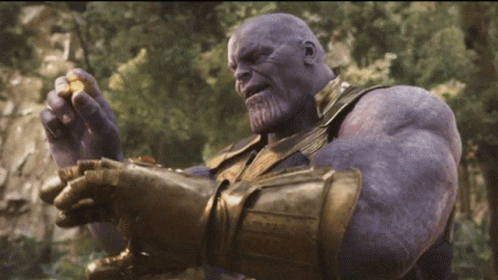

In [49]:
ibridoDellaMorteITA = model.fit(X, y)

In [53]:
predictions = model.predict(X)
predictions

array([1, 1, 1, ..., 0, 0, 0])

In [68]:
predictions[:20]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [67]:
predictions[20:40]

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [69]:
predictions[40:60]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [70]:
train_dataframe['recommendation_xgb'] = pd.Series(predictions, index=train_dataframe.index)
train_dataframe

user_id  item_id  item_popularity  user_profile_len  item_length  \
0             0        2           5085.0                54           21   
1             0      108            585.0                54            1   
2             0      175           1144.0                54            1   
3             0      111            557.0                54           26   
4             0      343           3643.0                54            0   
...         ...      ...              ...               ...          ...   
822315    41628     1670           1286.0                23            1   
822316    41628      403            755.0                23            0   
822317    41628    12124             39.0                23           15   
822318    41628     1259           1152.0                23            0   
822319    41628     2656            325.0                23            0   

        item_type  recommended  recommendation_xgb  
0               4            1                   1  
1               1            1                   1  
2               1            1                   1  
3               4            1                   1  
4               0            1                   0  
...           ...          ...                 ...  
822315          3            0                   0  
822316          0            0                   0  
822317          4            0                   0  
822318          0            0                   0  
822319          0            0                   0  

[822320 rows x 8 columns]

In [77]:
reranked_df = train_dataframe.sort_values(by=['user_id', 'recommendation_xgb'], ascending=[True, False])

In [89]:
target = pd.read_csv(filepath_or_buffer="/kaggle/input/recommender-system-2022-challenge-polimi/data_target_users_test.csv",
                                          sep=",",
                                          header=0,
                                          engine='python',
                                          names=['id'])

In [106]:
def write_reranked_recommendations(file_name):
    recommendations = 'user_id,item_list'
    f = open(file_name + ".csv", "w")

    for id in target['id']:
        recommendations_per_user = reranked_df.loc[reranked_df['user_id'] == id].item_id.values[:10]

        recommendation_string = str(user_original_Id_to_index[user_original_Id_to_index==id].index.item()
                                    ) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(item_original_ID_to_index[item_original_ID_to_index==rec].index.item()) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [104]:
def write_recommendations(recommender, file_name):
    recommendations = 'user_id,item_list'
    f = open(file_name + ".csv", "w")

    for id in target['id']:
        recommendations_per_user = recommender.recommend(user_id_array=id, remove_seen_flag=True, cutoff=10)

        recommendation_string = str(user_original_Id_to_index[user_original_Id_to_index==id].index.item()
                                    ) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(item_original_ID_to_index[item_original_ID_to_index==rec].index.item()) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [105]:
write_recommendations(recommender = recommender, file_name = "submission_norerank")

In [109]:
write_reranked_recommendations(file_name = "submission_rerank")

In [110]:
my_submission = pd.read_csv("submission_rerank.csv")
my_submission

user_id                                          item_list
0            0          22 617 18484 752 391 673 2488 25 2494 828
1            1              20420 61 56 393 62 352 450 21 23 6874
2            2    121 7864 8819 453 21319 6712 1308 1616 1311 672
3            3             20 21 58 352 917 613 393 130 11100 121
4            4                23 21 80 124 68 348 56 436 2106 353
...        ...                                                ...
41111    41624  22403 7864 10221 617 18939 752 22441 14809 881...
41112    41625                53 23 21 1898 393 909 56 25 498 596
41113    41626              270 124 21 53 58 3546 393 20 23 12118
41114    41627    1214 1514 1212 19705 17880 1859 71 1561 95 5069
41115    41628          771 769 21 22 1022 3596 2904 929 1004 763

[41116 rows x 2 columns]